# Trump - Fake News on twitter analysis
- pending: adding all days missing in fake_news df to calculate frequency between tweets

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

In [2]:
plt.rcParams['figure.figsize'] = (20, 12)

## Trump data

In [3]:
# Using twitterscrape: 'twitterscraper from:RealDonaldTrump --output=trump.json'
# old_trump = pd.read_json('data/old-trump.json')
# print(old_trump.shape)
# print(old_trump.columns)

In [202]:
# Using twint: twint -u realDonaldTrump -o trump.json --json
trump = pd.read_json('data/trump.json', lines=True)
print(trump.shape)
print(trump.columns)

(40301, 31)
Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'mentions', 'urls',
       'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'near', 'geo',
       'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_date'],
      dtype='object')


## Add missing dates

In [203]:
# Complete groupby function by adding missing days 
# https://stackoverflow.com/questions/55883057/python-fill-zeros-in-a-timeseries-dataframe

# Check first for missing dates in the series
dates = pd.date_range(start = fake_news.index.min(), end = fake_news.index.max()).difference(fake_news.index)
print('Days missing: {}'.format(len(dates)))

Days missing: 711


In [ ]:
# trump.index = pd.DatetimeIndex(trump.index)

# https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe

## Functions

In [5]:
data_sources = [trump]

In [6]:
#Make text for twitter lowercase to search for matching expressions

for sources in data_sources:
    sources['text_lower'] = sources.tweet.str.lower()

#### Count all fake news expressions

In [7]:
# Find given expressions in tweets

def fake_news_mentions(data, match = []):
        
    #find patterns
    for i in match:
        data[i] = data['text_lower'].str.contains(i)

    # Convert True/False values to 0/1
    data[match] = data[match].astype('int32')
        
    # Create column with fake_news label
    data['total_fake_news_mention'] = data[match].sum(axis=1)
    data['label'] = np.where(data['total_fake_news_mention']>0, 1, 0)
    
    # Summary messages
    print('Total fake_news labels: {}'.format(data.label.sum()))
    print('Media mentions: {}'.format(len(data[data['text_lower'].str.contains('media')])))


#### Aggregate tweets by day, data summary, plot

In [9]:

def aggregate_tweets_day(data, title_vis):
    
    global fake_news
    
    # Group data by date
    d = {'created_at':'tweets_per_day'}
    new_df = data.groupby(data.created_at.dt.date).\
        agg({'created_at':'count', 'label':'sum'}).rename(columns=d)
    
    # Create new df including only tweets with expressions 
    fake_news = new_df[new_df['label'] > 0]
    
    # Calculate tweet frequency. Pending: add missing days
    res = fake_news.index.to_series().diff()
    
    # Scatter plot
    fake_news.plot(style='o', alpha = 0.5)
    plt.title(title_vis)

    # Summary messages
    print('- Total number of fake_news tweets: {}'.format(fake_news.label.sum()))
    print('- First fake_news tweet: {}'.format(fake_news.index.min()))
    print('- Last tweet: {}'.format(fake_news.index.max()))
    print('- Average frequency: {}'.format(res.mean()))
    
    

## Trump

In [11]:
trump_expressions = ['fake news', 'false news', 'fake media', 'falsenews', 'fakemedia', 'enemy of the people']
fake_news_mentions(trump, trump_expressions)

Total fake_news labels: 570
Media mentions: 1007


- Total number of fake_news tweets: 570
- First fake_news tweet: 2016-11-16
- Last tweet: 2019-11-11
- Average frequency: 2 days 21:01:25.488126


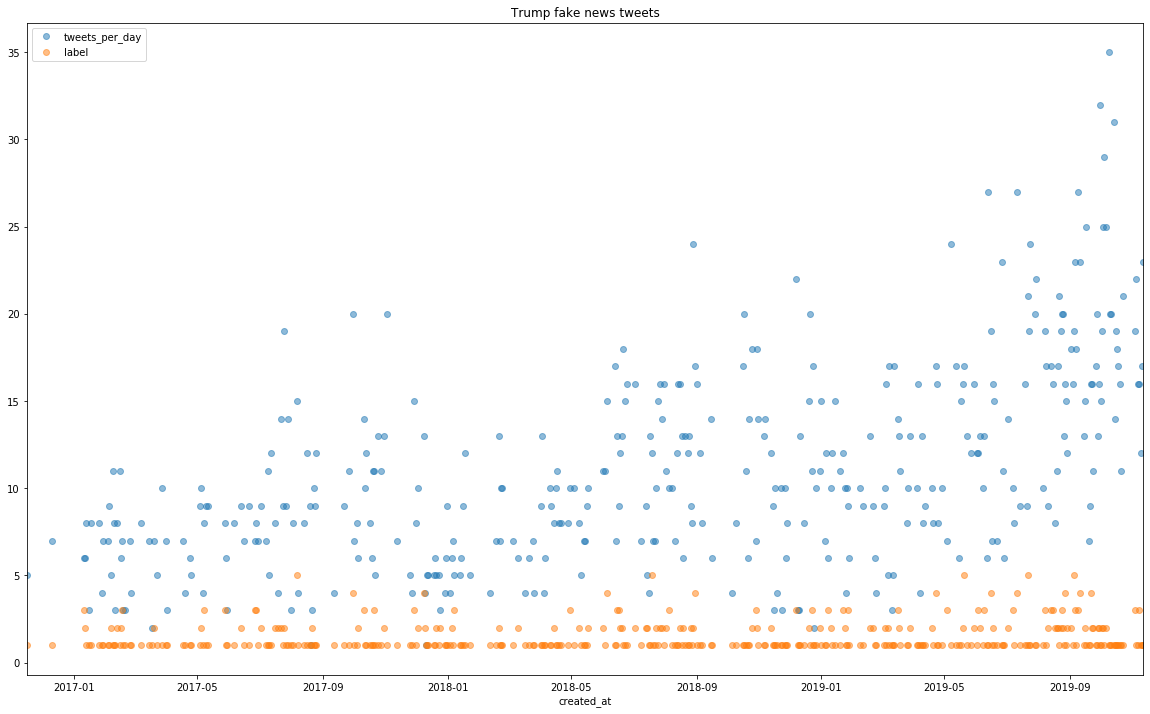

In [13]:
aggregate_tweets_day(trump, "Trump fake news tweets")

## Group data by week

In [19]:
# Aggregate data by week
trump['week'] = pd.to_datetime(trump['date']) - pd.to_timedelta(7, unit='d')


In [151]:
df = trump.groupby([pd.Grouper(key='week', freq='W-MON')])\
        .agg({'label':'sum', 'id':'count'}).reset_index().sort_values('week')

df.head()

,week,label,id
0,2009-04-27,0,2
1,2009-05-04,0,2
2,2009-05-11,0,8
3,2009-05-18,0,6
4,2009-05-25,0,3


In [169]:
# Create new df including only tweets with expressions 
df['fake_news'] = np.where(df['label'] > 0, 1, 0)
df['all_records'] = 1
df.head()

,week,label,id,fake_news,all_records
0,2009-04-27,0,2,0,1
1,2009-05-04,0,2,0,1
2,2009-05-11,0,8,0,1
3,2009-05-18,0,6,0,1
4,2009-05-25,0,3,0,1


In [172]:
plt.rcParams['figure.figsize'][0]

20.0

Number of weeks with fake_news tweets: 137


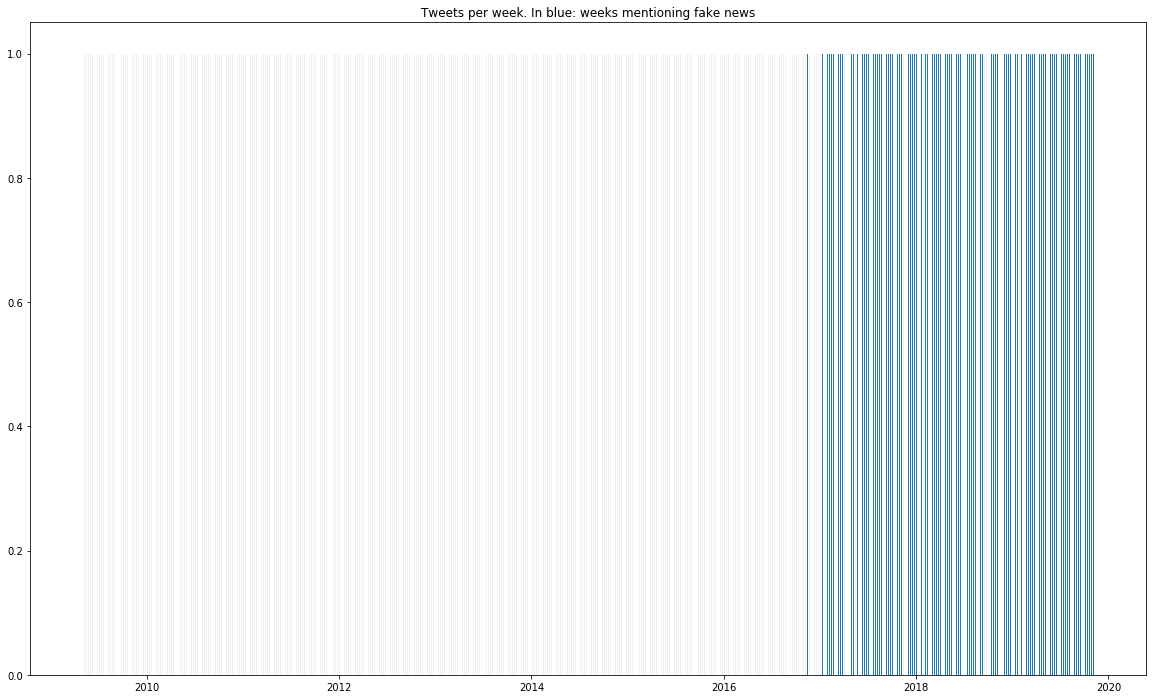

In [204]:
# bar width 
spacing = 25
wplot = len(df.week)/(plt.rcParams['figure.figsize'][0])-spacing

#plot
plt.bar(df.week, df.all_records, width = wplot, color = 'lightgray', alpha = 0.3)
plt.bar(df.week, df.fake_news, width = wplot)
plt.title("Tweets per week. In blue: weeks mentioning fake news")

print('Number of weeks with fake_news tweets: {}'.format(df.fake_news.sum()))